In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import tensorflow as tf


# from IPython.display import clear_output
from time import sleep
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow import keras as keras

from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential

# from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import  ReLU, Activation, BatchNormalization, Flatten, Dense, Dropout, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, EarlyStopping

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

%matplotlib inline
%load_ext tensorboard

print("tensorflow version : ${}".format(tf.__version__))

Using TensorFlow backend.


tensorflow version : $1.15.0


In [2]:
# Use GPU if anabled
# 
# import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1655276738250821434
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8962267139279244558
physical_device_desc: "device: XLA_CPU device"
]


[]

In [3]:
filename_training = './training.csv'
filename_test = './test.csv'
filename_lookup = './IdLookupTable.csv'
filename_samplesubmission = './SampleSubmission.csv'

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96

FEATURES_COUNT = 31

ROWS_COUNT_TRAINING = 7049
ROWS_COUNT_TRAINING_VALID = 2140
ROWS_COUNT_TEST = 1783

In [4]:
def load_file(filename=None, cols=None):
    if filename is None:
        print("ERROR: No file")
        return
    df = pd.read_csv(filename)
    df['Image'] = df['Image'].apply(lambda row: np.fromstring(row, dtype=int, sep=' '))
    print(df.info()) 
#     @TODO: test it with different fill it time left...
#     df.fillna(method = 'ffill', inplace = True)
    df = df.dropna()
#     df = df.iloc[:250]
    print(df.info()) 
    return df

In [5]:
input_training = load_file(filename_training)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [6]:
def show_images_grid(df, image_from_index=0):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(
        left = 0, 
        right = 1, 
        bottom = 0, 
        top = 1, 
        hspace = 0.05, 
        wspace = 0.05
    )
    plt_images_count = 16
    for index in range(0, plt_images_count):
        ax = fig.add_subplot(4, 4, index + 1, xticks=[], yticks=[])
#         curr_index = np.random.randint(2140)
        curr_index = image_from_index + index
        if curr_index in df.index:
            image_raw = df['Image'][curr_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT))
            image = plt.imshow(image_raw, cmap='gray')
            for i in range(1, FEATURES_COUNT, 2):
                image_dots_x = df.loc[index][i-1]
                image_dots_y = df.loc[index][i]
                plt.plot(image_dots_x, image_dots_y, 'or')

    plt.show()

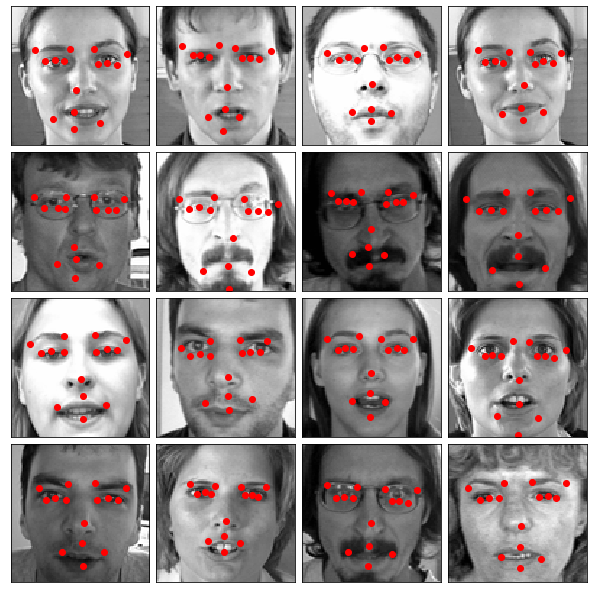

In [7]:
show_images_grid(input_training, image_from_index=20)

In [8]:
X_training = np.asarray([input_training['Image']], dtype = np.uint8).reshape(input_training.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)
y_training = input_training.drop(['Image'], axis = 1)
y_training = y_training.to_numpy()
print(X_training.shape)
print(y_training.shape)

(2140, 96, 96, 1)
(2140, 30)


In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(X_training, y_training, test_size = 0.3)
print("X_train")
print(X_train.shape)
print(X_train.shape)
print("X_test")
print(X_test.shape)
print(X_test.shape)
print("y_train")
print(y_train.shape)
print(y_train.shape)
print("y_test")
print(y_test.shape)
print(y_test.shape)

X_train
(1498, 96, 96, 1)
(1498, 96, 96, 1)
X_test
(1783, 96, 96, 1)
(1783, 96, 96, 1)
y_train
(1498, 30)
(1498, 30)
y_test
(1783, 1)
(1783, 1)


In [24]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(3,3), activation="relu", padding = 'same', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation="relu", padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation="relu", padding = 'same'))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

model.summary()

# Input+1
# model.add(Conv2D(filters = 32, kernel_size=(3,3), padding = 'same', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 32, kernel_size=(3,3), padding = 'same'))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (2, 2)))

# Section - 
# model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'same'))
# model.add(Activation("relu"))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64, kernel_size=(3,3), padding = 'same'))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size = (2, 2)))

# Final
# model.add(Flatten())

# model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.3))

# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.1))

# model.add(Dense(30))

# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [25]:
model.compile(optimizer='Adam', 
              loss='mse', 
              metrics=['accuracy', 'mse', 'mape'])

In [26]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs_miw_low", now)
tensorboard = TensorBoard(
    log_dir = logdir,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.5,
    patience = 20,
    verbose = 1,
    restore_best_weights=True
)

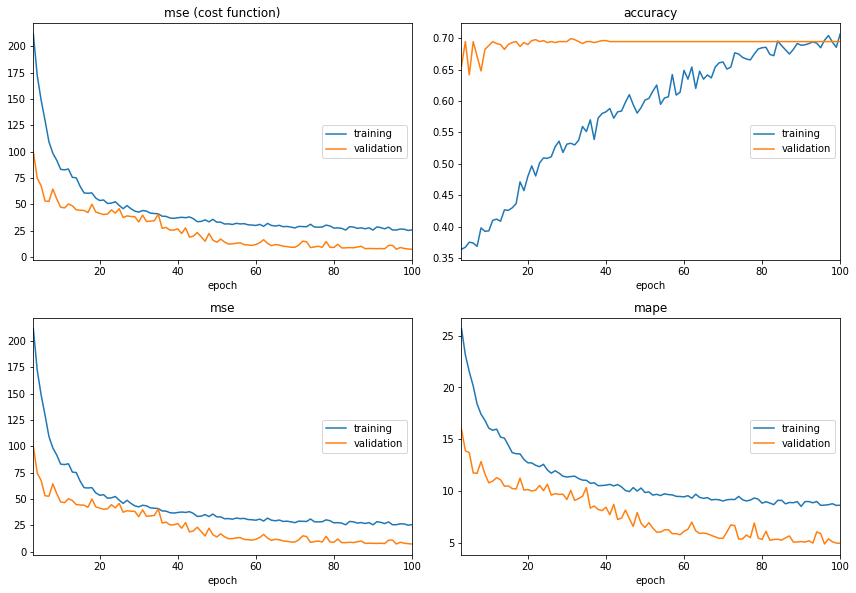

mse (cost function):
training   (min:   25.216, max:  905.784, cur:   25.696)
validation (min:    7.339, max:  130.216, cur:    7.339)

accuracy:
training   (min:    0.228, max:    0.707, cur:    0.707)
validation (min:    0.642, max:    0.699, cur:    0.695)

mse:
training   (min:   25.216, max:  905.784, cur:   25.696)
validation (min:    7.339, max:  130.216, cur:    7.339)

mape:
training   (min:    8.530, max:   50.624, cur:    8.641)
validation (min:    4.900, max:   19.504, cur:    4.981)


In [27]:
# hist = model.fit(
#     X_train, 
#     y_train, 
#     epochs = 10, 
# #     callbacks = [tensorboard],
# #     batch_size = 256,
# #     validation_split = 0.2,
# #     validation_data = (X_validation, y_validation)
# )


# hist = model.fit(
#     X_training, 
#     y_training, 
#     epochs = 100, 
#     callbacks = [tensorboard, PlotLossesCallback(), earlystop],
#     validation_split = 0.3
# )

hist = model.fit(
    X_train, 
    y_train, 
    epochs = 100, 
    callbacks = [tensorboard, PlotLossesCallback(), earlystop],
    validation_data = (X_validation, y_validation)
)

In [28]:
def show_loss_graph(history):
    plt.figure(figsize=(4,4))
    loss = history['loss']
    val_loss = history['val_loss']
    loss = np.sqrt(np.array(loss)) 
    val_loss = np.sqrt(np.array(val_loss)) 
    plt.plot(loss, "--", linewidth = 3, label = "training")
    plt.plot(val_loss, linewidth = 3, label = "validation")
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


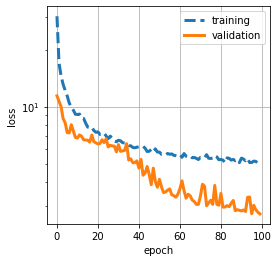

In [29]:
# print(hist.history)
show_loss_graph(hist.history)

In [30]:
# model.save('miw_2020.h5')

In [31]:
input_test = load_file(filename_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 41.8+ KB
None


In [32]:
X_test = np.asarray([input_test['Image']], dtype = np.uint8).reshape(input_test.shape[0], IMAGE_WIDTH, IMAGE_HEIGHT, 1)
# y_test = input_test.drop(['Image'], axis = 1)
# y_test = y_test.to_numpy()
y_test_predict = model.predict(X_test)
y_training_predict = model.predict(X_training)

print(y_test_predict)
print(y_training_predict)


[[64.986565 35.70229  29.511398 ... 68.687164 47.68027  79.9308  ]
 [67.5576   37.52729  30.259735 ... 74.104095 49.1747   84.11374 ]
 [64.290016 35.30948  29.63752  ... 68.80957  48.683773 78.31093 ]
 ...
 [67.951385 37.758587 30.811922 ... 74.2147   49.388725 84.22169 ]
 [65.11988  36.70011  29.283781 ... 73.70808  47.299385 81.77948 ]
 [66.78493  37.710304 30.132578 ... 74.86784  48.42882  83.67622 ]]
[[67.13272  38.295197 30.2348   ... 74.19565  47.715527 84.71554 ]
 [63.836445 35.74997  28.893496 ... 69.19234  45.91523  79.569   ]
 [64.63403  35.475155 29.678946 ... 68.586525 48.038395 78.83709 ]
 ...
 [69.54929  39.404785 30.862417 ... 78.0985   49.467793 87.76875 ]
 [66.271194 36.135036 30.111702 ... 74.54123  50.399952 81.83209 ]
 [64.667595 35.31924  29.475534 ... 71.25228  49.030014 79.520515]]


In [35]:
# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [38]:
def show_predict_images_grid(df, y_init, y_predict, image_from_index=0):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(
        left = 0, 
        right = 1, 
        bottom = 0, 
        top = 1, 
        hspace = 0.05, 
        wspace = 0.05
    )
    plt_images_count = 16
    for index in range(0, plt_images_count):
        ax = fig.add_subplot(4, 4, index + 1, xticks=[], yticks=[])
        curr_index = np.random.randint(2140)
#         curr_index = np.random.randint(100)
#         curr_index = image_from_index + index
        image_raw = df[curr_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT))
        image = plt.imshow(image_raw, cmap='gray')
        for i in range(1, FEATURES_COUNT, 2):
            image_dots_x1 = y_init[index][i - 1]
            image_dots_y1 = y_init[index][i]
            plt.plot(image_dots_x1, image_dots_y1, 'or')
            image_dots_x2 = y_predict[index][i - 1]
            image_dots_y2 = y_predict[index][i]
            plt.plot(image_dots_x2, image_dots_y2, 'x', color='lime')

    plt.show()

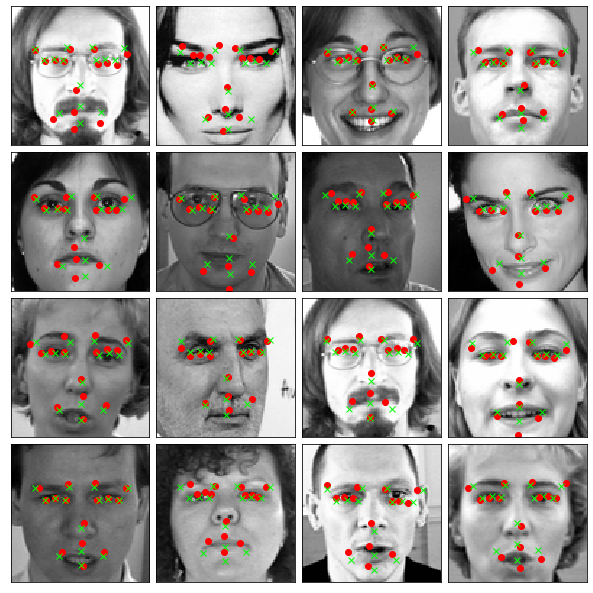

In [40]:
show_predict_images_grid(X_training, y_training, y_test_predict)

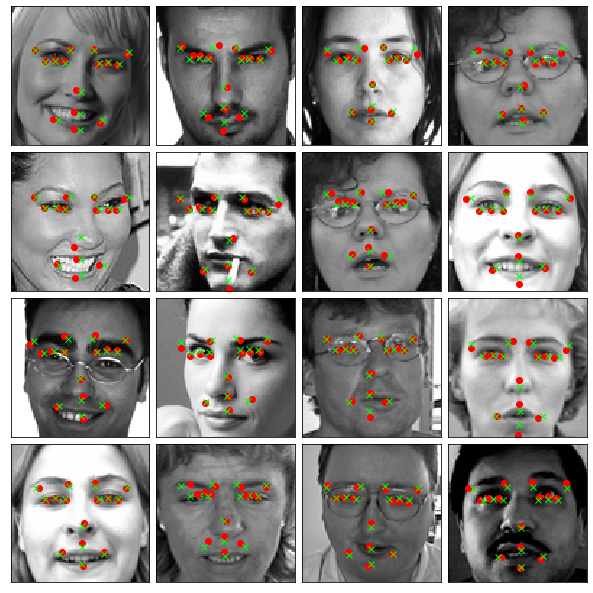

In [41]:
show_predict_images_grid(X_training, y_training, y_training_predict)

In [42]:
input_lookup = pd.read_csv(filename_lookup)
header = list(input_training.drop(['Image'], axis = 1).columns)
test_predicts = pd.DataFrame(y_test_predict, columns = header)

for i in range(input_lookup.shape[0]):
    image_index = input_lookup.ImageId[i] - 1
    feature_index = input_lookup.FeatureName[i]
    input_lookup.Location[i] = test_predicts.loc[image_index][feature_index]

/home/robson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
input_samplesubmission = pd.read_csv(filename_samplesubmission)
input_samplesubmission.Location = input_lookup.Location
miw_submission = input_samplesubmission
miw_submission.to_csv('miw_submission.csv', index = False)
print(miw_submission)

       RowId   Location
0          1  64.986565
1          2  35.702290
2          3  29.511398
3          4  35.982525
4          5  58.736610
...      ...        ...
27119  27120  37.708267
27120  27121  48.151112
27121  27122  58.930660
27122  27123  48.428822
27123  27124  83.676224

[27124 rows x 2 columns]
